<a href="https://colab.research.google.com/github/Lucile-S/ART_project/blob/main/WCGAN_Painting_by_GENRE_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## packages

In [ ]:
!pip install tensorboard
!pip install "tqdm==4.43.0"
import os
from time import sleep
from tqdm import tqdm
from glob import iglob
import pandas as pd
import pandas as pd

from collections import Counter
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torchvision.utils import save_image
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image
import torch.nn.functional as F
from scipy import linalg
from PIL import Image
import cv2
import copy
import urllib
import time
from datetime import datetime
import collections 

%matplotlib inline

     |████████████████████████████████| 59 kB 6.2 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires tqdm>=4.48.0, but you have tqdm 4.43.0 which is incompatible.


## Classes

In [ ]:
class Artist(object):
    """
    Artist Object
    """
    def __init__(self, folder_path:str, label_id=None ):
        self._path = folder_path.replace('\\',r'/')
        self._label_id = label_id

    @property
    def folder_name(self):
        return os.path.basename(self._path)

    @property
    def name(self):
      return os.path.basename(self._path).replace('-',' ').title()

    @property
    def path(self):
        return self._path
    
    @property
    def painting_paths(self):
        return list(iglob(self._path + '/*.jpg'))

    @property
    def painting_titles(self):
        return [ os.path.basename(painting_path).replace('.jpg','').replace('-',' ').capitalize() for painting_path in iglob(self._path + '/*.jpg') ]

    @property
    def painting_nb(self):
      return len(list(iglob(self._path + '/*.jpg')))

    @property
    def label(self):
        # just one label_id
        if isinstance(self._label_id, int):
            return self._label_id
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._label_id]
  

class Painting(object):
    """
    Painting Object
    """
    def __init__(self, painting_path:str):
        self._path = painting_path.replace('\\',r'/')
        self._json = self._path.replace('.jpg','.json')
        self._data = open_json_file(self._json)
        self._filename = os.path.basename(self._json).replace('.json','')
        self._key = list(self._data.keys())[0]

    @property
    def data(self):
      return  self._data


    @property
    def filename(self):
      return  self._filename


    @property
    def name(self):
      return  self._data[self._key]['Name']

    @property
    def artist(self):
      return  self._data[self._key]['Artist']


    @property
    def date(self):
      return self._data[self._key]['Date']
  
  
    @property
    def style(self):
      return self._data[self._key]['Style']
    
    @property
    def genre(self):
      return self._data[self._key]['Genre']

        
    @property
    def tags(self):
      return self._data[self._key]['Tags']

class Art_Dataset(Dataset):
    """
    Args:
        image_paths (list): list of image paths.
        df (pandas dataframe) : dataframe containning images names and encoding labels 
        classes (list): list of classes.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, image_paths:list, labels:list, transform =None):
      self.image_paths = image_paths
      self.labels = labels 
      self.transform  = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        #print(f'--- GET ITEM  # {index} ---')
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB') 
        label =  self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label, image_path


class CustomResize(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        old_size = img.size  # old_size[0] is in (width, height) format

        ratio = float(self.size)/min(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])

        return img.resize(new_size, resample=self.interpolation)

## utils

In [ ]:
## utils

def MakeDir(DIR:str) -> None:
    try:
        if not os.path.exists(DIR):
            os.makedirs(DIR)
    except OSError as err:
        print(err)
        pass

def show_batch(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    try: 
      image_unflat = image_tensor.detach().cpu()
    except: 
      image_unflat = image_tensor
      
    plt.figure(figsize = (12,12))
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

def gradient_penalty(critic, labels, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])
    

def show_tensor_images(image_tensor, num_images=25, size=(1,64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

def save_samples(index, epoch, fixed_noise, fixed_labels,  stats , sample_dir = '.', resize_size=128, show=True):
    fake_images = gen(fixed_noise, fixed_labels)
    fake_fname = f'Wcgan-bygenre-generated-images-{index:0=5d}-epoch-{epoch:0=4d}.jpg'
    save_image(denorm(transforms.Resize(resize_size)(fake_images), stats).clamp(0, 1), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.detach().cpu(), stats), nrow=8).permute(1, 2, 0).squeeze())
        plt.show()


def denorm(img_tensors, stats):
    return img_tensors * stats[1][0] + stats[0][0]


## Models

In [ ]:
"""
Discriminator and Generator implementation from DCGAN paper
"""

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes,  img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.channels_img = channels_img
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(self.channels_img + num_classes , features_d, kernel_size=4, stride=2, padding=1),
            #nn.Conv2d(self.channels_img +1 , features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
        self.embed = nn.Embedding(num_classes, num_classes)
        #self.embed = nn.Embedding(num_classes, img_size*img_size)


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        #embedding =  self.embed(labels).view(labels.shape[0], self.channels_img, self.img_size, self.img_size) # it's like an additional channel ; # N x C x H x W
        embedding =   self.embed(labels)[:,:,None,None].repeat(1, 1, self.img_size, self.img_size) # N x N_classes x IMG_SIZE x IMG_siSE
       
        x = torch.cat([x, embedding], dim=1)

        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise + embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes,embed_size)
        #self.embed = nn.Embedding(num_classes,num_classes)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


# FID

In [ ]:
import torchvision.models as models
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


In [ ]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/MyDrive/ /mydrive

%cd mydrive

!ls /mydrive/GAN/

[Errno 2] No such file or directory: 'mydrive'
/content
Data  generated  logs  Models


In [ ]:
!ls /mydrive/GAN/Data

amedeo-modigliani      gustav-klimt		      pierre-auguste-renoir
arnold-bocklin	       henri-matisse		      piet-mondrian
artemisia-gentileschi  henri-rousseau		      rembrandt
Artists.csv	       john-james-audubon	      sandro-botticelli
claude-monet	       joseph-mallord-william-turner  theophile-steinlen
david-burliuk	       katsushika-hokusai	      vassily-kandinsky
edward-hopper	       pablo-picasso		      vincent-van-gogh
ernst-ludwig-kirchner  Paintings.csv		      zdzislaw-beksinski


In [ ]:
# -----------#
#    DATA    #
# -----------#
BY_GENRE = True
BY_ARTIST= False

# -- image Directory 
DIR = '/mydrive/GAN' 
img_DIR = os.path.join(DIR,'Data')
artist_paths =  [ artist_path for artist_path  in iglob(img_DIR +'/*') if os.path.isdir(artist_path)]
# -- list of Artist instance
ARTISTS  = [Artist(artist_path) for artist_path in artist_paths]
print(f'There are {len(artist_paths)} artists')
print(artist_paths)

artist_csv_path = os.path.join(img_DIR, 'Artists.csv')
df_artist = pd.read_csv(artist_csv_path, sep=";")
painting_csv_path = os.path.join(img_DIR, 'Paintings.csv')


if BY_ARTIST:

    # -- create mapping dictionnary for Artist (in alphabetic order)
    artist_map_dic = {k: v for v, k in enumerate(sorted([ARTIST.name for ARTIST in ARTISTS ]))   }
    print(artist_map_dic)
    print(len(artist_map_dic))

    # -- save DIR   
    sample_dir = os.path.join(DIR,'generated','Wcgan')
    os.makedirs(sample_dir, exist_ok=True)

    model_save_DIR = os.path.join(DIR,'Models')

    all_painting_paths = []
    all_labels  = []

    for artist_path in artist_paths:
        # -- create artist instance 
        artist = Artist(artist_path)
        #print(f'--{artist.name}--')
        artist_id =  artist_map_dic[artist.name]
        # -- get list of painting paths
        painting_paths = artist.painting_paths
        # -- add to all all_painting_paths 
        all_painting_paths.extend(painting_paths)
        all_labels.extend([artist_id] * artist.painting_nb)

    print(len(all_painting_paths))
    print(all_painting_paths[1000:1005])
    print(len(all_labels))
    print(all_labels[1000:1005])

There are 22 artists
['/mydrive/GAN/Data/zdzislaw-beksinski', '/mydrive/GAN/Data/rembrandt', '/mydrive/GAN/Data/arnold-bocklin', '/mydrive/GAN/Data/gustav-klimt', '/mydrive/GAN/Data/katsushika-hokusai', '/mydrive/GAN/Data/pablo-picasso', '/mydrive/GAN/Data/vincent-van-gogh', '/mydrive/GAN/Data/ernst-ludwig-kirchner', '/mydrive/GAN/Data/theophile-steinlen', '/mydrive/GAN/Data/joseph-mallord-william-turner', '/mydrive/GAN/Data/sandro-botticelli', '/mydrive/GAN/Data/amedeo-modigliani', '/mydrive/GAN/Data/artemisia-gentileschi', '/mydrive/GAN/Data/piet-mondrian', '/mydrive/GAN/Data/edward-hopper', '/mydrive/GAN/Data/pierre-auguste-renoir', '/mydrive/GAN/Data/claude-monet', '/mydrive/GAN/Data/henri-rousseau', '/mydrive/GAN/Data/henri-matisse', '/mydrive/GAN/Data/david-burliuk', '/mydrive/GAN/Data/john-james-audubon', '/mydrive/GAN/Data/vassily-kandinsky']


### BY GENRE 

In [ ]:
if BY_GENRE:
    filename ='Paintings.csv'
    df = pd.read_csv(os.path.join(img_DIR,'Paintings.csv'), sep=';')
    print(df.tail(5))

    # -- convert Tags column to tuples
    # df['Tags'] = df['Tags'].apply(eval)

    # -- Genre
    Genres = df['Genre'].unique()
    print('Genres:', Genres)
    print(f'There are {len(Genres)}')

    print(df.groupby('Genre')['Filename'].count())

    # -- Tags
    # --- replace empty tags by NaN
    df['Tags'] = df['Tags'].replace('()', np.nan)
    all_Tags  = []

    for t in  list(df['Tags'].dropna().values) :
        t = t.replace(')', ',)') # because one elemnt tuple need to be in the form (item,)
        t = eval(t)
        if len(t) > 1:
            for item in t:
                all_Tags.append(item)
        else: 
            try:
                all_Tags.append(t[0])
            except:
                pass

    print(f'all_Tags {all_Tags[-5]}')
    # -- count frequency of tags
    print('')
    print('Tag counting : ')
    Tag_Counts = Counter(elem for elem in all_Tags)

    print(Tag_Counts)

    limit = 400
    # -- select paintings by genre
    painting_by_genre ={}
    Genres =['flower painting','landscape','nude painting (nu)','portrait','still life','illustration']
    for genre in Genres:
        painting_list = list(df[df['Genre']==genre]['Filename'])
        if len(painting_list) > limit :
            # -- add .jpg 
            painting_list = [painting for painting in painting_list]
            painting_by_genre[genre] = painting_list


    # -- create mapping dictionnary for Artist (in alphabetic order)
    genre_map_dic = {k: v for v, k in enumerate(sorted([genre for genre in painting_by_genre.keys()]))   }
    print('Genre map dic :', genre_map_dic)
    print('Number of genre:', len(painting_by_genre))
    # -- example of painting list for one giving genre 
    #print(painting_by_genre['figurative'])


    # -- save DIR   
    sample_dir = os.path.join(DIR,'generated','Wcgan','by_genre_2')
    os.makedirs(sample_dir, exist_ok=True)

    model_save_DIR = os.path.join(DIR,'Models','by_genre_2')
    os.makedirs(model_save_DIR , exist_ok=True)

    log_dir = os.path.join(DIR,'logs','Wcgan','by_genre_2')

    #all_painting_filenames = []
    all_painting_paths = []
    all_labels  = []

    #print(df[df['Filename']=='spring-1907']['Artist'].values[0])

    def get_painting_path(painting_filename):
        artist = df[df['Filename']==painting_filename]['Artist'].values[0]
        artist = str(artist).lower().replace(' ','-')
        painting_path  = os.path.join(img_DIR, artist, painting_filename+'.jpg')
        return painting_path 

    for genre in sorted(painting_by_genre.keys()):
        print(genre)
        genre_id =  genre_map_dic[genre]
        print(genre_id)
        # -- get list of painting paths
        painting_filenames = painting_by_genre[genre]
        painting_paths  = list(map(get_painting_path,painting_filenames))
        # -- add to all all_painting_paths 
        all_painting_paths.extend(painting_paths)
        all_labels.extend([genre_id] * len(painting_paths))
        print('---')

                               Filename  ...              Artist
12396      plate-78-great-carolina-wren  ...  John James Audubon
12397                plate-13-snow-bird  ...  John James Audubon
12398   plate-19-louisiana-water-thrush  ...  John James Audubon
12399  plate-127-rose-breasted-grosbeak  ...  John James Audubon
12400   plate-130-yellow-winged-sparrow  ...  John James Audubon

[5 rows x 7 columns]
Genres: ['allegorical painting' 'religious painting' 'portrait' nan
 'mythological painting' 'landscape' 'symbolic painting'
 'history painting' 'battle painting' 'sketch and study' 'self-portrait'
 'literary painting' 'still life' 'sculpture' 'nude painting (nu)'
 'animal painting' 'interior' 'poster' 'cityscape' 'illustration'
 'advertisement' 'design' 'bird-and-flower painting' 'pastorale' 'vanitas'
 'marina' 'cloudscape' 'flower painting' 'panorama' 'figurative'
 'abstract' 'architecture' 'wildlife painting' 'quadratura']
There are 34
Genre
abstract                     191
adve

In [ ]:
print('-------------')
print(len(all_painting_paths))
print(all_painting_paths[3100:3105])
print(len(all_labels))
print(all_labels[3100:3105])

-------------
6430
['/mydrive/GAN/Data/henri-matisse/the-port-of-belle-isle-sur-mer-1897.jpg', '/mydrive/GAN/Data/henri-matisse/belle-isle-tempete-1896.jpg', '/mydrive/GAN/Data/henri-matisse/the-windshield-1917-0.jpg', '/mydrive/GAN/Data/henri-matisse/olive-trees-at-collioure-1906.jpg', '/mydrive/GAN/Data/henri-matisse/landscape-1898.jpg']
6430
[2, 2, 2, 2, 2]


In [ ]:
if BY_ARTIST:
    NUM_CLASSES  = 22
if BY_GENRE:
    NUM_CLASSES = 6
BATCH_SIZE = 32
fixed_labels  = torch.tensor(list(np.arange(0,NUM_CLASSES))*15)[:BATCH_SIZE] # to have dim 64 
print(fixed_labels)
print('Lenght fixed labels :' , len(fixed_labels))

tensor([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
        0, 1, 2, 3, 4, 5, 0, 1])
Lenght fixed labels : 32


##  TRAIN

In [ ]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1.0e-4
BATCH_SIZE = 32
IMG_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 124
NUM_EPOCHS_START = 900
NUM_EPOCHS = NUM_EPOCHS_START + 1000
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 7
GENERATOR_ITERATIONS = 1
LAMBDA_GP = 10 # gradient penalty
GENERATOR_EMBEDDING  = NUM_CLASSES 
NUM_DISPLAY = 500
SAVE_EPOCH = 50


stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
date = datetime.now().strftime("%Y_%m_%d")

transformations = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)


# -- dataset dataloader
# --- artist 
dataset = Art_Dataset(all_painting_paths, all_labels, transform=transformations)

loader = DataLoader(dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True)

## SHOW ONE BATCH

tensor([3, 2, 3, 0, 3, 4, 3, 2, 4, 5, 2, 1, 4, 4, 2, 2, 4, 5, 5, 3, 2, 3, 5, 1,
        3, 2, 0, 4, 5, 3, 4, 4])
('/mydrive/GAN/Data/theophile-steinlen/femme-nue-assise-s-essuyant-les-pieds-1902.jpg', '/mydrive/GAN/Data/claude-monet/on-the-cliff-near-dieppe.jpg', '/mydrive/GAN/Data/ernst-ludwig-kirchner/practising-dancer.jpg', '/mydrive/GAN/Data/henri-matisse/a-bunch-of-flowers-1907.jpg', '/mydrive/GAN/Data/pablo-picasso/nude-green-leaves-and-bust-1932.jpg', '/mydrive/GAN/Data/rembrandt/dr-ephraim-bueno-jewish-physician-and-writer-1647.jpg', '/mydrive/GAN/Data/pablo-picasso/seated-bather-1930.jpg', '/mydrive/GAN/Data/katsushika-hokusai/the-pontoon-bridge-at-sano-in-the-province-of-kozuka.jpg', '/mydrive/GAN/Data/henri-matisse/figure-at-the-rideau-releve.jpg', '/mydrive/GAN/Data/pierre-auguste-renoir/still-life-with-peaches-2.jpg', '/mydrive/GAN/Data/edward-hopper/rocky-shore-and-sea.jpg', '/mydrive/GAN/Data/john-james-audubon/plate-25-song-sparrow.jpg', '/mydrive/GAN/Data/pierre-august

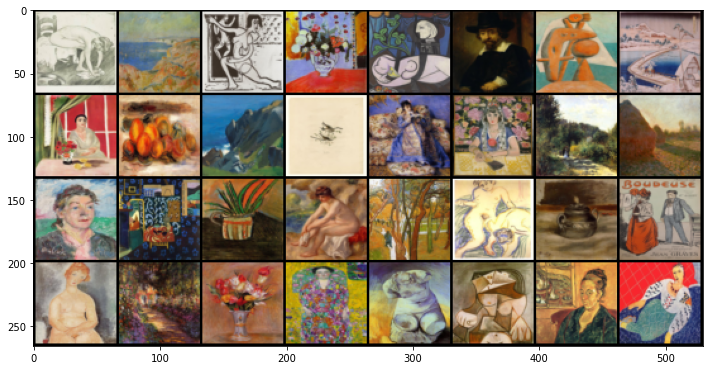

In [ ]:
stop = 0
for i, (images, labels, image_paths) in  enumerate(loader):
  print(labels)
  print(image_paths)
  show_batch(images, num_images=32, size=(3, BATCH_SIZE, BATCH_SIZE), nrow=8, show=True)
  if i == stop:
    break

In [ ]:
# # --- Mnist 
# dataset = datasets.MNIST(root="dataset/", transform=transformations, download=True)
# loader = DataLoader(
#     dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
# )

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GENERATOR_EMBEDDING).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES,IMG_SIZE).to(device)

# initializate optimizer

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9)) # with α = 0.0002, β1 = 0.0 and β2 = 0.9. 
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

ckpt_path  = f'/mydrive/GAN/Models/by_genre_2/2021_10_05_WcGAN_BYGENRE_v2_{NUM_EPOCHS_START}_latest.pkl'
#ckpt_path = None
if ckpt_path is not None:
    ckpt = torch.load(ckpt_path)
    gen.load_state_dict(ckpt['gen_state_dict'])
    critic.load_state_dict(ckpt['disc_state_dict'])
    opt_gen.load_state_dict(ckpt['gen_optimizer_state_dict'])
    opt_critic.load_state_dict(ckpt['disc_optimizer_state_dict'])
else: 
    initialize_weights(gen)
    initialize_weights(critic)


# for tensorboard plotting
fixed_noise = torch.randn(BATCH_SIZE , Z_DIM, 1, 1).to(device)
fixed_labels  = torch.tensor(list(np.arange(0,NUM_CLASSES))*10)[:BATCH_SIZE].to(device)
#fixed_labels  = torch.tensor(list(np.arange(0,NUM_CLASSES))*6+[0,0,0,0]).to(device) # to have dim 64 

writer  =  SummaryWriter(log_dir)
writer_real = SummaryWriter(os.path.join(log_dir,'real'))
writer_fake = SummaryWriter(os.path.join(log_dir,'fake'))

gen.train()
critic.train()

generator_losses = []
critic_losses =[]

step = 0

for epoch in range(NUM_EPOCHS_START, NUM_EPOCHS):
    for batch_idx, (real, labels, path) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels = labels.to(device)
        mean_iteration_critic_loss =0
        mean_iteration_generator_loss=0

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            # print('critic_shape',critic_real.shape)
            # print(labels.shape)
            gp = gradient_penalty(critic,labels, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += loss_critic.item() / CRITIC_ITERATIONS
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        critic_losses += [mean_iteration_critic_loss]

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        for _ in range(GENERATOR_ITERATIONS):
            gen_fake = critic(fake, labels).reshape(-1)
            loss_gen = -torch.mean(gen_fake)
            gen.zero_grad()
            # Keep track of the average critic loss in this batch
            mean_iteration_generator_loss += loss_gen.item() / GENERATOR_ITERATIONS
            loss_gen.backward()
            opt_gen.step()

        generator_losses += [mean_iteration_generator_loss]


        # Print losses occasionally and print to tensorboard
        if step % NUM_DISPLAY == 0 and step > 0:
            gen_mean_loss = sum(generator_losses[-NUM_DISPLAY:]) / NUM_DISPLAY 
            crit_mean_loss = sum(critic_losses[-NUM_DISPLAY:]) / NUM_DISPLAY 

            # FID 
            fretchet_dist=calculate_fretchet(real,fake,model)

            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] | Step {step} | Batch {batch_idx}/{len(loader)} \
                  Loss G: {gen_mean_loss:.4f}, loss D: {crit_mean_loss:.4f} , FID: {fretchet_dist:.4f}"
            )


            with torch.no_grad():
                # print('fixed_noise shape :', fixed_noise.shape)
                # print('fixed_labels shape :', fixed_labels.shape)
                #fake = gen(fixed_noise, fixed_labels)
                fake = gen(noise, labels)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                # -- writer
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

                # -- write to writer
                writer.add_scalar("loss_gen", gen_mean_loss, step)
                writer.add_scalar("loss_critic", crit_mean_loss, step)

                print('--real images ---')
                show_tensor_images(real)
                print('--fake images ---')
                show_tensor_images(fake)

                step_bins = 20
                num_examples = (len(generator_losses) // step_bins) * step_bins
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Loss"
                )
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Discriminator Loss"
                )
                plt.legend()
                plt.show()

                print('saving images generated with fixed noise')
                save_samples(step, epoch, fixed_noise, fixed_labels, stats, sample_dir = sample_dir, resize_size=128, show=False)    
       
        step += 1
    # -- save the model at the end of the epoch 
    if epoch % SAVE_EPOCH == 0 and epoch > 0:
        torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': critic.state_dict(),
        'gen_optimizer_state_dict': opt_gen.state_dict(),
        'disc_optimizer_state_dict': opt_critic.state_dict(),
        }, os.path.join(model_save_DIR, f'{date}_WcGAN_BYGENRE_v2_{epoch}_latest.pkl'))

        save_samples(len(loader), epoch,fixed_noise,fixed_labels, stats,sample_dir = sample_dir, resize_size=128, show=True)  

        print('------------------------------------------------------------------------------------')


In [ ]:
writer.flush()
writer_real.flush()
writer_fake.flush()
writer_real.close()
writer_fake.close()
writer.close()

In [ ]:
log_dir

## tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=log_dir

In [ ]:
!ls /content/gdrive/MyDrive/GAN/logs/Wcgan/art_2


In [ ]:
%reload_ext tensorboard

In [ ]:
rferf

## OLD TRAIN

In [ ]:

# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 124
NUM_EPOCHS = 2
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
IMG_SIZE= 64
NUM_CLASSES = 10
GENERATOR_EMBEDDING  = 10

transformations = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transformations, download=True)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GENERATOR_EMBEDDING).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES,IMG_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(BATCH_SIZE , Z_DIM, 1, 1).to(device)
fixed_labels  = torch.tensor(list(np.arange(0,NUM_CLASSES))*6+[0,0,0,0]).to(device) # to have dim 64 
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0
# -- save DIR   
DIR = '/mydrive/GAN' 
sample_dir = os.path.join(DIR,'generated','Wcgan','art_2')
os.makedirs(sample_dir, exist_ok=True)
model_save_DIR = os.path.join(DIR,'Models','art_2')


gen.train()
critic.train()

generator_losses = []
critic_losses =[]
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, labels) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels = labels.to(device)
        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic,labels,  real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
            critic_losses += [loss_critic.item()]

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        
        generator_losses += [loss_gen.item()]
        

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                # print('fixed_noise shape :', fixed_noise.shape)
                # print('fixed_labels shape :', fixed_labels.shape)
                fake = gen(fixed_noise, fixed_labels)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

                print('--real images ---')
                show_tensor_images(real)
                print('--fake images ---')
                show_tensor_images(fake)

                step_bins = 20
                num_examples = (len(generator_losses) // step_bins) * step_bins
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Loss"
                )
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Discriminator Loss"
                )
                plt.legend()
                plt.show()
                print('saving images generated with fixed noise')
                save_samples(step, epoch, fixed_noise, fixed_labels,sample_dir = sample_dir, resize_size=128, show=False)  

            step += 1